<a href="https://colab.research.google.com/github/ainesko/ML_HW/blob/main/Decision_Trees_Became_a_Solved_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений решают проблемы

***Суммарное количество баллов: 10***

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений.

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [130]:
import numpy as np
import pandas as pd
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib
from scipy.stats import mode
import math

#Задание 1 (1 балл)

Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения.

Описание функций
gini(x) считает коэффициент Джини для массива меток

entropy(x) считает энтропию для массива меток

gain(left_y, right_y, criterion) считает информативность разбиения массива меток на левую left_y и правую right_y части при помощи criterion, который задается функцией (не строкой).

In [131]:
def gini(x):
    x = list(x)
    GI = x.count(0) / len(x) * (1 - x.count(0) / len(x)) + x.count(1) / len(x) * (1 - x.count(1) / len(x))
    return GI

def entropy(x):
    s = list(set(x))
    Entr = 0
    for i in range(len(s)):
      Entr -= x.count(s[i]) / len(x) * math.log2(x.count(s[i]) / len(x))
    return Entr

def gain(left_y, right_y, criterion):
    IG = 1 * criterion(np.hstack((left_y, right_y))) - len(left_y) / len (left_y + right_y) * criterion(left_y) - len(right_y) / len(left_y + right_y) * criterion(right_y)
    return IG

#Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева.

***DecisionTreeLeaf***

Поля:

1.   y должно содержать класс, который встречается чаще всего среди элементов листа дерева

***DecisionTreeNode***


В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:


1.   split_dim измерение, по которому разбиваем выборку
2.   split_value значение, по которому разбираем выборку
3.   left поддерево, отвечающее за случай x[split_dim] < split_value. Может быть DecisionTreeNode или DecisionTreeLeaf
4.   right поддерево, отвечающее за случай x[split_dim] >= split_value. Может быть DecisionTreeNode или DecisionTreeLeaf


Интерфейс классов можно и нужно менять при необходимости (например, для вычисления вероятности в следующем задании)

In [132]:
class DecisionTreeLeaf:
    def __init__(self, y_t):
        self.y = mode(y_t)[0][0]
        self.prob = {}
        coun_y = Counter(y_t)
        for key, value in coun_y.items():
          self.prob[key] = value / len(y_t)
        
    def predict_proba(self, x):
        return self.prob


class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        
    def predict_proba(self, x):
        indx = x[self.split_dim].index[0]
        if x[self.split_dim][indx] < self.split_value:
            return self.left.predict_proba(x)
        else:
            return self.right.predict_proba(x)

#Задание 3 (6 баллов)

Теперь перейдем к самому дереву решений. Реализуйте класс DecisionTreeClassifier.

***Описание методов***

fit(X, y) строит дерево решений по обучающей выборке.

predict_proba(X) для каждого элемента из X возвращает словарь dict, состоящий из пар (класс, вероятность). Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе.

***Описание параметров конструктора***

criterion="gini" - задает критерий, который будет использоваться при построении дерева. Возможные значения: "gini", "entropy".

max_depth=None - ограничение глубины дерева. Если None - глубина не ограничена

min_samples_leaf=1 - минимальное количество элементов в каждом листе дерева.

***Описание полей***

root - корень дерева. Может быть DecisionTreeNode или DecisionTreeLeaf

In [133]:
class DecisionTreeClassifier:
    def __init__(self, criterion='gini', max_depth=None, min_samples_leaf=1):
        self.root = None
        if criterion == 'gini':
            self.criterion = gini
        else:
            self.criterion = entropy
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):
        self.root = self.step(X, y, 1)
        
    def step(self, X, y, tree_depth):
        if tree_depth >= self.max_depth:
            return DecisionTreeLeaf(y)
        bscore = -np.inf
        bcolmn = None
        bvalue = None
        bindx = None
        for col in X.columns:
            X = X.sort_values(by=col)
            y = y[X.index]
            prev_value = None
            for i, value in enumerate(X[col]):
                if value != prev_value:
                    prev_value = value
                    if (i >= self.min_samples_leaf) and (len(y) >= self.min_samples_leaf + i):
                        score = gain(y[:i], y[i:], self.criterion)
                        if score > bscore:
                            bscore = score
                            bcolmn = col
                            bvalue = value
                            bindx = i
        if bcolmn is None:
            return DecisionTreeLeaf(y) 
        X = X.sort_values(by=bcolmn)
        return DecisionTreeNode(split_dim=bcolmn, split_value=bvalue, left=self.step(X[:bindx], y[X[:bindx].index], tree_depth+1), 
                                right=self.step(X[bindx:], y[X[bindx:].index], tree_depth+1))
    
    def predict_proba(self, X):
        return [self.root.predict_proba(X[i:i+1]) for i in range(len(X))]
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод draw_tree рисует дерево и сохраняет его в указанный файл.

In [134]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, f"x[{tree_root.split_dim}] < {tree_root.split_value:g}",
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [135]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

#Задание 4 (2 балла)

Протестируйте решение на датасете spam. Для этой задачи используйте данные x_spam_train и y_spam_train:

1.    Выполните загрузку и предобработку файлов x_spam_train и y_spam_train.
2.    Разбейте x_spam_train и y_spam_train на x_train, y_train, x_test и y_test для оценки точности работы алгоритма.
3.    Посчитайте метрики precision, recall, accuracy для модели Decision Tree. Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.
4.    Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки sklearn).
5.    Ответьте на следующие вопросы:


*   Какой нужен препроцессинг данных для моделей?

*Из данных следует убрать столбцы 'Id', так как в нём нет стоящих данных, при этом столбец добавляет строковый тип к столбцам x.*

*   Какая модель делает предсказания лучше? Предположите, почему.


*Decision Tree предсказывает лучше. Скорее всего, это за счёт перебора почти всех вариантов, мы получаем лучший вариант предсказания.*

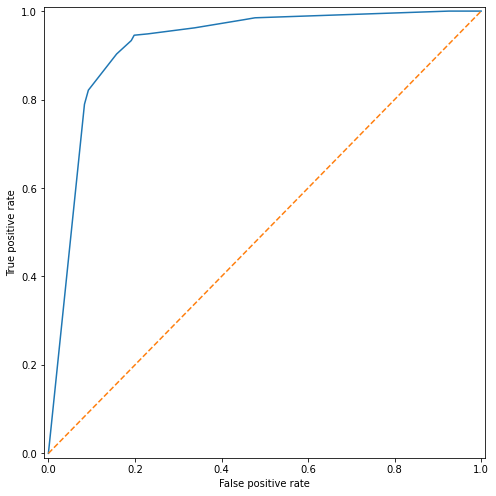

In [136]:
X, y = pd.read_csv("x_spam_train.csv"), pd.read_csv("y_spam_train.csv")
X_train, y_train = X.iloc[:round(len(X)*0.7)], y['Expected'].iloc[:round(len(X)*0.7)]
X_test, y_test = X.iloc[round(len(X)*0.7):], y['Expected'].iloc[round(len(X)*0.7):]
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train.drop('Id', axis=1), y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))

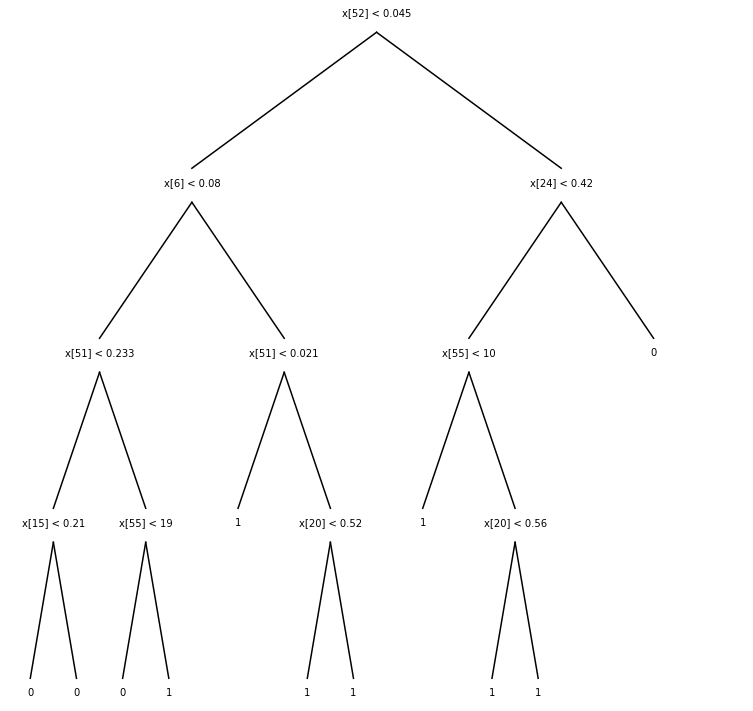

In [137]:
draw_tree(tree)

###Метрики для модели Decision Tree

In [138]:
y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy}')
print(f'recall = {recall}')
print(f'precision = {precision}')
print(f'f1-score = {f1}')

accuracy = 0.8831521739130435
recall = 0.8085585585585585
precision = 0.890818858560794
f1-score = 0.8476977567886659


### Метрики для модели kNN

In [139]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [140]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'accuracy = {accuracy}')
print(f'recall = {recall}')
print(f'precision = {precision}')
print(f'f1-score = {f1}')

accuracy = 0.7065217391304348
recall = 0.5563063063063063
precision = 0.660427807486631
f1-score = 0.6039119804400978


1.    Обучите модель на всех данных из x_spam_train и y_spam_train.
2.    Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [141]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
X = pd.read_csv('x_spam_train.csv')
y = pd.read_csv('y_spam_train.csv')
X_test = pd.read_csv('x_spam_test.csv')
tree.fit(X, y['Expected'])
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = X_test["Id"]
submission["Expected"] = tree.predict(X_test)
submission

FileNotFoundError: ignored